# Simulating Pipe Flow on a Staggered Grid in Python

**작성자**: Donghui Son  
**날짜**: 2025년 7월 30일

---

## 소개

본 포스트는 *[Simulating Pipe Flow on a Staggered Grid in Python](https://youtu.be/rV8tD2nQfkk?si=equHEHjt1qi7jGZg)* 영상을 바탕으로 정리한 내용입니다. 주제는 '파이프 내부의 층류 유동' 시뮬레이션이며, 특히 staggered grid 기법을 활용한 Navier-Stokes 방정식의 수치해법에 초점을 맞춥니다.

## 물리적 배경

![층류와 난류의 차이](../img/posts/pipe_flow_simulation_tutorial_sdh/laminar_turbulent_flows.jpg)

*이미지 출처: [Demystifying Fluid Turbulence, Velocity and Flow Measurement](https://www.automation.com/en-us/articles/2018/demystifying-fluid-turbulence-velocity-and-flow-me)*


### Reynolds 수와 유동 특성

유동의 특성은 무차원 Reynolds 수(Re)로 특징지어진다:

$$Re = \frac{\rho U L}{\mu} = \frac{U L}{\nu}$$

여기서:
- $\rho$: 유체 밀도 [kg/m³]
- $U$: 특성 속도 [m/s]
- $L$: 특성 길이 [m]
- $\mu$: Dynamic viscosity [Pa·s]
- $\nu$: Kinematic viscosity ($\nu = \mu/\rho$) [m²/s]


#### 층류-난류 천이 기준

**내부 유동 (e.g., pipe flow)**:
- 층류: Re << 2,000
- 천이 영역: Re ≈ 2,000-4,000 (조건 의존적)
- 난류: Re >> 2,000

**외부 유동 (e.g., boundary layer)**: 외부 유동의 천이 영역은 단일 Reynolds 수로 정의할 수 없고, 다양한 인자들의 복합 함수로 주어진다. 하지만 대략적으로 Re ≈ 5×10⁵를 기준으로 사용한다고 한다.
- 층류: Re << 5×10⁵
- 난류: Re >> 5×10⁵

천이 영역에서는 유동의 안정성이 표면 거칠기(파이프가 얼마나 smooth한지), 입구 조건(속도 분포 균일성), 기계적/음향적 교란 등 외부 요인에 크게 영향을 받는다.


### Hagen-Poiseuille 유동

Fully developed(완전히 발달된?.. 정상상태에 도달한) 축대칭 층류 파이프 유동에서 속도 분포는 포물선 형태를 보이며, 해석해는 다음과 같다:

$$u(r) = u_{max}\left(1 - \frac{r^2}{R^2}\right) = \frac{\Delta P R^2}{4 \mu L}(1 - \frac{r^2}{R^2})$$

여기서:
- $u(r)$: $r$ 위치에서의 축방향 속도
- $u_{max}$: 파이프 중심축($r=0$)에서의 최대 속도
- $R$: 파이프 반지름
- $\Delta P = P_{in} - P_{out}$: 파이프 양단의 압력차
- $L$: 파이프 길이

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

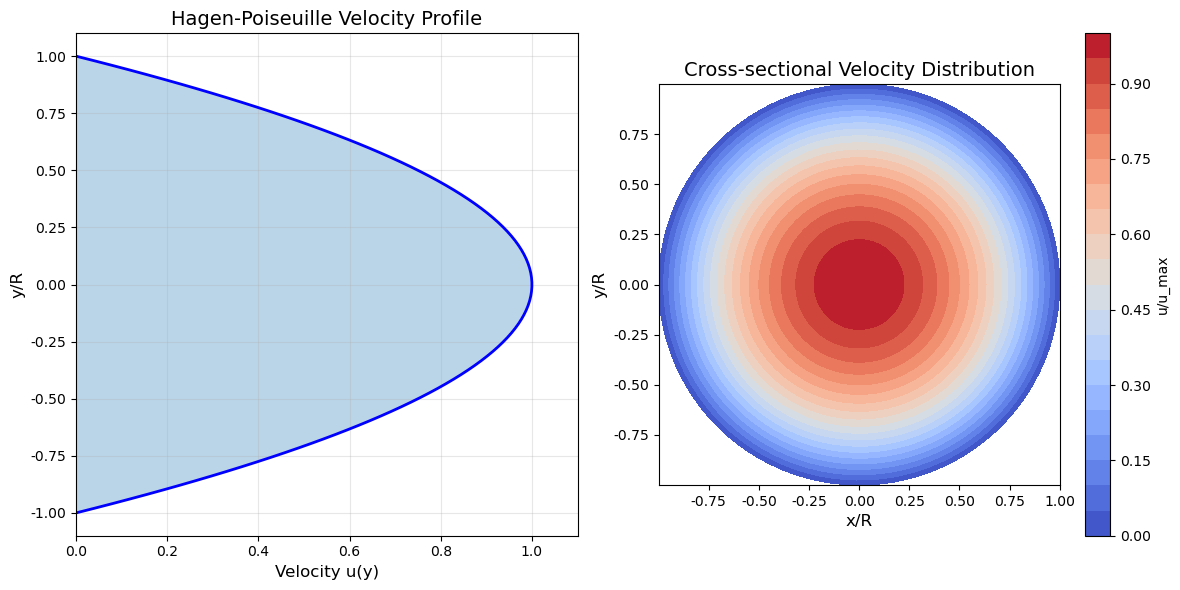

In [3]:
# Hagen-Poiseuille profile visualization
def plot_hagen_poiseuille():
    y = np.linspace(-1, 1, 100)
    u_max = 1.0
    u = u_max * (1 - y**2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left plot: velocity profile
    ax1.plot(u, y, 'b-', linewidth=2)
    ax1.fill_betweenx(y, 0, u, alpha=0.3)
    ax1.set_xlabel('Velocity u(y)', fontsize=12)
    ax1.set_ylabel('y/R', fontsize=12)
    ax1.set_title('Hagen-Poiseuille Velocity Profile', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1.1)
    
    # Right plot: cross-section (circular pipe)
    theta = np.linspace(0, 2*np.pi, 100)
    r = np.linspace(0, 1, 50)
    R, Theta = np.meshgrid(r, theta)
    U = u_max * (1 - R**2)
    
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    
    contour = ax2.contourf(X, Y, U, levels=20, cmap='coolwarm')
    ax2.set_xlabel('x/R', fontsize=12)
    ax2.set_ylabel('y/R', fontsize=12)
    ax2.set_title('Cross-sectional Velocity Distribution', fontsize=14)
    ax2.set_aspect('equal')
    
    plt.colorbar(contour, ax=ax2, label='u/u_max')
    plt.tight_layout()
    plt.show()

plot_hagen_poiseuille()

## 수학적 모델링

### Navier-Stokes 방정식

#### 1. 운동량 방정식 (Momentum Equation)

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}$$


#### 2. 연속 방정식 (Continuity Equation)

비압축성 유체의 경우:

$$\nabla \cdot \mathbf{u} = 0$$

이는 유체의 질량이 보존됨을 의미한다.


### 2차원 형태

2차원 직교 좌표계에서 방정식을 전개하면:

**운동량 방정식(x-component):**

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$

**운동량 방정식(y-component):**

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)$$

**연속 방정식:**

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$


### 경계 조건

1. **입구 (왼쪽)**: 균일한 속도 프로파일
   - $u = 1.0$
   - $v = 0.0$

2. **출구 (오른쪽)**: Outflow
   - $\frac{\partial u}{\partial x} = 0$
   - $\frac{\partial v}{\partial x} = 0$

3. **벽 (위/아래)**: 점착 조건 (no-slip)
   - $u = 0$
   - $v = 0$

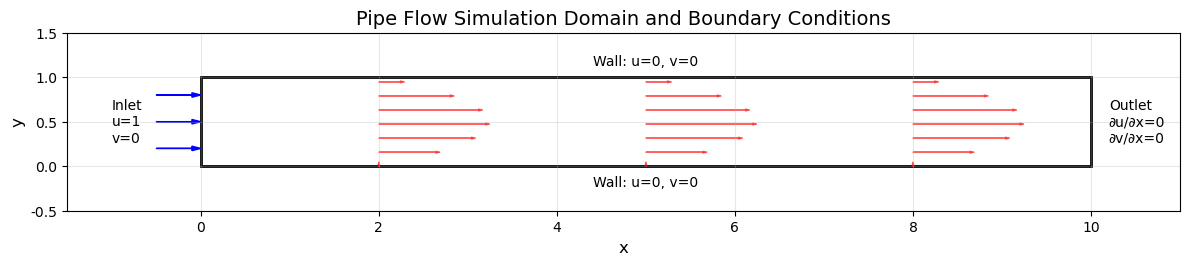

In [4]:
# Visualize simulation domain
def visualize_domain():
    fig, ax = plt.subplots(figsize=(12, 10))
    
    domain = plt.Rectangle((0, 0), 10, 1, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(domain)
    
    # Inlet condition
    ax.arrow(-0.5, 0.2, 0.4, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.arrow(-0.5, 0.5, 0.4, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.arrow(-0.5, 0.8, 0.4, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.text(-1.0, 0.5, 'Inlet\nu=1\nv=0', ha='left', va='center', fontsize=10)
    
    # Outlet condition
    ax.text(10.2, 0.5, 'Outlet\n∂u/∂x=0\n∂v/∂x=0', ha='left', va='center', fontsize=10)
    
    # Wall condition
    ax.text(5, 1.1, 'Wall: u=0, v=0', ha='center', va='bottom', fontsize=10)
    ax.text(5, -0.1, 'Wall: u=0, v=0', ha='center', va='top', fontsize=10)
    
    # Flow profile example
    x_positions = [2, 5, 8]
    for x_pos in x_positions:
        y = np.linspace(0, 1, 20)
        u_profile = 1.5 * y * (1 - y) * 4  # Parabolic profile
        for i in range(0, len(y), 3):
            ax.arrow(x_pos, y[i], u_profile[i]*0.8, 0, 
                    head_width=0.02, head_length=0.05, fc='red', ec='red', alpha=0.6)
    
    ax.set_xlim(-1.5, 11)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title('Pipe Flow Simulation Domain and Boundary Conditions', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_domain()

## 수치 해법

### Staggered Grid의 필요성

#### Co-located Grid의 문제점

모든 변수(u, v, p)를 같은 위치에 저장하는 co-located grid는 압력의 체커보드 패턴 문제를 야기한다:

```
p₁ - p₂ - p₃
|    |    |
p₄ - p₅ - p₆
```

중앙 차분을 사용하면 p₂가 위치한 곳에서의 압력 구배는 (p₃-p₁)/2Δx가 되어, p₂ 자신의 값이 무시된다.


#### Staggered Grid 해결책

변수들을 서로 다른 위치에 저장하여 이 문제를 해결한다:

```
+ - ↑ - + - ↑ - +
|       |       |
→   •   →   •   →
|       |       |
+ - ↑ - + - ↑ - +
```

- `•`: 압력 (p)
- `→`: x-방향 속도 (u)
- `↑`: y-방향 속도 (v)
- `+`: 격자 꼭짓점


### 유한 차분법

#### 공간 미분

중앙 차분 근사:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i+1} - f_{i-1}}{2\Delta x}$$

2차 미분 (라플라시안):

$$\frac{\partial^2 f}{\partial x^2} \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{\Delta x^2}$$


#### 시간 적분

명시적 오일러 방법:

$$f^{n+1} = f^n + \Delta t \cdot \frac{\partial f}{\partial t}^n$$


### 압력 보정 기법 (SIMPLE 알고리즘)

비압축성 조건을 만족시키기 위한 압력-속도 연계 알고리즘:

1. **예측 단계**: 이전 시간의 압력을 사용하여 임시 속도 계산
   
   $$\mathbf{u}^* = \mathbf{u}^n + \Delta t \left( -\nabla p^n + \nu \nabla^2 \mathbf{u}^n - (\mathbf{u}^n \cdot \nabla)\mathbf{u}^n \right)$$

2. **압력 보정**: Poisson 방정식 해결
   
   $$\nabla^2 q = \frac{\nabla \cdot \mathbf{u}^*}{\Delta t}$$

3. **속도 보정**: 비압축성 만족
   
   $$\mathbf{u}^{n+1} = \mathbf{u}^* - \Delta t \nabla q$$
   $$p^{n+1} = p^n + q$$

## 코드 구현 상세 분석

In [5]:
# Simulation parameters
class PipeFlowSimulation:
    def __init__(self, n_points_y=15, aspect_ratio=10, 
                 kinematic_viscosity=0.01, time_step=0.001):
        """
        Initialize pipe flow simulation
        
        Parameters:
        -----------
        n_points_y : int
            Number of grid points in y direction
        aspect_ratio : float
            Aspect ratio (length/height)
        kinematic_viscosity : float
            Kinematic viscosity (ν)
        time_step : float
            Time step (Δt)
        """
        self.n_points_y = n_points_y
        self.aspect_ratio = aspect_ratio
        self.kinematic_viscosity = kinematic_viscosity
        self.dt = time_step
        
        # Set grid size
        self.cell_length = 1.0 / (n_points_y - 1)
        self.n_points_x = (n_points_y - 1) * aspect_ratio + 1
        
        # Create coordinates
        self.x_range = np.linspace(0.0, 1.0 * aspect_ratio, self.n_points_x)
        self.y_range = np.linspace(0.0, 1.0, self.n_points_y)
        self.X, self.Y = np.meshgrid(self.x_range, self.y_range)
        
        # Check stability
        self.check_stability()
        
        # Initialize variables
        self.initialize_fields()
        
    def check_stability(self):
        """Check numerical stability condition"""
        # Diffusion stability condition: (ν Δt) / (ΔL²) ≤ 1/2
        diffusion_number = (self.kinematic_viscosity * self.dt) / (self.cell_length**2)
        
        print(f"Δx: {self.cell_length:.4f}")
        print(f"Δt: {self.dt:.4f}")
        print(f"Diffusion number: {diffusion_number:.4f} (condition: < 0.5)")
        
        if diffusion_number > 0.5:
            print("Warning: Simulation might explode!")
        else:
            print("Stability condition satisfied! Safe to run")
            
        # Reynolds number calculation
        Re = 1.0 * 1.0 / self.kinematic_viscosity  # U*L/ν
        print(f"Reynolds number: {Re:.1f}")
        
    def initialize_fields(self):
        """Initialize velocity and pressure fields"""
        # Set array sizes for staggered grid
        # u: (ny+1) × nx (staggered grid)
        self.u = np.ones((self.n_points_y + 1, self.n_points_x))
        self.u[0, :] = -self.u[1, :]    # Bottom wall boundary condition
        self.u[-1, :] = -self.u[-2, :]  # Top wall boundary condition
        
        # v: (ny) × (nx+1) (staggered grid)
        self.v = np.zeros((self.n_points_y, self.n_points_x + 1))
        
        # p: (ny+1) × (nx+1) (staggered grid)
        self.p = np.zeros((self.n_points_y + 1, self.n_points_x + 1))
        
        print(f"\nInitialization complete!")
        print(f"u array size: {self.u.shape}")
        print(f"v array size: {self.v.shape}")
        print(f"p array size: {self.p.shape}")

# Simulation object creation
sim = PipeFlowSimulation()

Δx: 0.0714
Δt: 0.0010
Diffusion number: 0.0020 (condition: < 0.5)
Stability condition satisfied! Safe to run
Reynolds number: 100.0

Initialization complete!
u array size: (16, 141)
v array size: (15, 142)
p array size: (16, 142)


In [6]:
# Time-marching algorithm implementation
def update_velocity_x(u_prev, v_prev, p_prev, dt, dx, nu):
    """
    x-direction velocity update (predictor step)
    
    Momentum equation: ∂u/∂t = -∂p/∂x + ν∇²u - ∂(u²)/∂x - v∂u/∂y
    """
    u_tent = np.zeros_like(u_prev)
    
    # Update internal points
    # Diffusion term: ν∇²u
    diffusion_x = nu * (
        (u_prev[1:-1, 2:] + u_prev[2:, 1:-1] + 
         u_prev[1:-1, :-2] + u_prev[:-2, 1:-1] - 
         4 * u_prev[1:-1, 1:-1]) / dx**2
    )
    
    # Convection term: u∂u/∂x + v∂u/∂y
    # x-direction convection: ∂(u²)/∂x
    convection_x_x = (
        (u_prev[1:-1, 2:]**2 - u_prev[1:-1, :-2]**2) / (2 * dx)
    )
    
    # y-direction convection: v∂u/∂y
    # v is staggered, so interpolation is needed
    v_at_u = (
        v_prev[1:, 1:-2] + v_prev[1:, 2:-1] + 
        v_prev[:-1, 1:-2] + v_prev[:-1, 2:-1]
    ) / 4
    
    convection_x_y = v_at_u * (
        (u_prev[2:, 1:-1] - u_prev[:-2, 1:-1]) / (2 * dx)
    )
    
    # Pressure gradient: -∂p/∂x
    pressure_gradient_x = (
        (p_prev[1:-1, 2:-1] - p_prev[1:-1, 1:-2]) / dx
    )
    
    # Time integration
    u_tent[1:-1, 1:-1] = u_prev[1:-1, 1:-1] + dt * (
        -pressure_gradient_x + diffusion_x - convection_x_x - convection_x_y
    )
    
    # Boundary conditions
    u_tent[1:-1, 0] = 1.0                   # Inlet: uniform velocity (inflow)
    u_tent[1:-1, -1] = u_tent[1:-1, -2]     # Outlet: ∂u/∂x = 0 (outflow)
    u_tent[0, :] = -u_tent[1, :]            # Bottom wall: u = 0 (no-slip)
    u_tent[-1, :] = -u_tent[-2, :]          # Top wall: u = 0 (no-slip)
    
    return u_tent

# Similarly, implement the y-direction velocity update function
def update_velocity_y(u_prev, v_prev, p_prev, dt, dx, nu):
    """
    y-direction velocity update (predictor step)
    """
    v_tent = np.zeros_like(v_prev)
    
    # Diffusion term
    diffusion_y = nu * (
        (v_prev[1:-1, 2:] + v_prev[2:, 1:-1] + 
         v_prev[1:-1, :-2] + v_prev[:-2, 1:-1] - 
         4 * v_prev[1:-1, 1:-1]) / dx**2
    )
    
    # Convection term
    # u is staggered, so interpolation is needed
    u_at_v = (
        u_prev[2:-1, 1:] + u_prev[2:-1, :-1] + 
        u_prev[1:-2, 1:] + u_prev[1:-2, :-1]
    ) / 4
    
    convection_y_x = u_at_v * (
        (v_prev[1:-1, 2:] - v_prev[1:-1, :-2]) / (2 * dx)
    )
    
    convection_y_y = (
        (v_prev[2:, 1:-1]**2 - v_prev[:-2, 1:-1]**2) / (2 * dx)
    )
    
    # Pressure gradient
    pressure_gradient_y = (
        (p_prev[2:-1, 1:-1] - p_prev[1:-2, 1:-1]) / dx
    )
    
    # Time integration
    v_tent[1:-1, 1:-1] = v_prev[1:-1, 1:-1] + dt * (
        -pressure_gradient_y + diffusion_y - convection_y_x - convection_y_y
    )
    
    # Boundary conditions
    v_tent[1:-1, 0] = -v_tent[1:-1, 1]      # no inflow (v = 0)
    v_tent[1:-1, -1] = v_tent[1:-1, -2]     # outflow
    v_tent[0, :] = 0.0                      # Bottom wall: v = 0 (no-slip)
    v_tent[-1, :] = 0.0                     # Top wall: v = 0 (no-slip)
    
    return v_tent

In [7]:
# Pressure correction algorithm
def solve_pressure_poisson(u_tent, v_tent, dt, dx, n_iterations=50):
    """
    Solve pressure Poisson equation
    ∇²q = (∇·u*) / Δt
    
    Use Jacobi iteration method
    """
    # Calculate divergence
    divergence = (
        (u_tent[1:-1, 1:] - u_tent[1:-1, :-1]) / dx +
        (v_tent[1:, 1:-1] - v_tent[:-1, 1:-1]) / dx
    )
    
    # RHS of Poisson equation
    rhs = divergence / dt
    
    # Jacobi iteration
    q = np.zeros((u_tent.shape[0], v_tent.shape[1]))
    
    for _ in range(n_iterations):
        q_new = np.zeros_like(q)
        
        # Update internal points
        q_new[1:-1, 1:-1] = 0.25 * (
            q[1:-1, 2:] + q[2:, 1:-1] + 
            q[1:-1, :-2] + q[:-2, 1:-1] - 
            dx**2 * rhs
        )
        
        # Pressure boundary conditions
        # Most of them are Neumann (∂q/∂n = 0)
        q_new[1:-1, 0] = q_new[1:-1, 1]      # Inlet (Neumann: ∂q/∂n = 0)
        q_new[1:-1, -1] = -q_new[1:-1, -2]   # Outlet (Dirichlet: q = 0)
        q_new[0, :] = q_new[1, :]            # Bottom wall (Neumann: ∂q/∂n = 0)
        q_new[-1, :] = q_new[-2, :]          # Top wall (Neumann: ∂q/∂n = 0)
        
        # Advance in smoothing
        q = q_new
    
    return q

def correct_velocities(u_tent, v_tent, q, dt, dx):
    """
    Correct velocity using pressure correction
    u^{n+1} = u* - Δt ∇q
    """
    u_next = np.copy(u_tent)
    v_next = np.copy(v_tent)
    
    # u velocity correction
    pressure_gradient_x = (q[1:-1, 2:-1] - q[1:-1, 1:-2]) / dx
    u_next[1:-1, 1:-1] = u_tent[1:-1, 1:-1] - dt * pressure_gradient_x
    
    # v velocity correction
    pressure_gradient_y = (q[2:-1, 1:-1] - q[1:-2, 1:-1]) / dx
    v_next[1:-1, 1:-1] = v_tent[1:-1, 1:-1] - dt * pressure_gradient_y
    
    # Reapply boundary conditions
    u_next[1:-1, 0] = 1.0 # Inflow (u = 1)
    
    # Adjust outlet velocity for mass conservation
    inflow_rate = np.sum(u_next[1:-1, 0])
    outflow_rate = np.sum(u_next[1:-1, -2])
    u_next[1:-1, -1] = u_next[1:-1, -2] * inflow_rate / outflow_rate # Outlet
    
    u_next[0, :] = -u_next[1, :] # Bottom wall (no-slip)
    u_next[-1, :] = -u_next[-2, :] # Top wall (no-slip)
    
    v_next[1:-1, 0] = -v_next[1:-1, 1] # No inflow (v = 0)
    v_next[1:-1, -1] = v_next[1:-1, -2] # Outflow
    v_next[0, :] = 0.0  # Bottom wall (no-slip)
    v_next[-1, :] = 0.0 # Top wall (no-slip)
    
    return u_next, v_next

## 시각화 및 결과 분석

In [8]:
# Simple simulation execution
def run_simulation(n_steps=5000, plot_interval=50):
    """
    Run pipe flow simulation
    """
    sim = PipeFlowSimulation(n_points_y=15, aspect_ratio=10, 
                           kinematic_viscosity=0.01, time_step=0.001)
    
    # List for storing results
    results = []
    
    # Time progression
    for step in range(n_steps):
        # 1. Predict velocity
        u_tent = update_velocity_x(sim.u, sim.v, sim.p, sim.dt, sim.cell_length, sim.kinematic_viscosity)
        v_tent = update_velocity_y(sim.u, sim.v, sim.p, sim.dt, sim.cell_length, sim.kinematic_viscosity)
        
        # 2. Pressure correction
        q = solve_pressure_poisson(u_tent, v_tent, sim.dt, sim.cell_length)
        
        # 3. Velocity correction
        sim.u, sim.v = correct_velocities(u_tent, v_tent, q, sim.dt, sim.cell_length)
        
        # 4. Update pressure
        sim.p += q
        
        # Store results
        if step % plot_interval == 0:
            # Convert to vertex-centered velocity
            u_vertex = (sim.u[1:, :] + sim.u[:-1, :]) / 2
            v_vertex = (sim.v[:, 1:] + sim.v[:, :-1]) / 2
            
            results.append({
                'step': step,
                'u': u_vertex.copy(),
                'v': v_vertex.copy(),
                'p': sim.p[1:-1, 1:-1].copy()
            })
    
    return sim, results

# Run simulation
print("Running simulation...")
sim, results = run_simulation(n_steps=5000, plot_interval=50)
print("Simulation completed!")

Running simulation...
Δx: 0.0714
Δt: 0.0010
Diffusion number: 0.0020 (condition: < 0.5)
Stability condition satisfied! Safe to run
Reynolds number: 100.0

Initialization complete!
u array size: (16, 141)
v array size: (15, 142)
p array size: (16, 142)
Simulation completed!


In [9]:
# Animation of flow development over time
def create_flow_animation(sim, results):
    """
    Create animation of flow development
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Initial settings
    levels = np.linspace(0, 1.6, 21)
    # contour = ax.contourf(sim.X, sim.Y, results[0]['u'], 
    #                      levels=levels, cmap='viridis', extend='both')
    contour = ax.contourf(sim.X, sim.Y, results[0]['u'], 
                         levels=levels, cmap='RdBu_r', extend='both')
    cbar = plt.colorbar(contour, ax=ax, label='u velocity', orientation='horizontal')
    
    # Velocity profile lines
    profile_lines = []
    x_positions = [10, 40, 80]
    colors = ['white', 'yellow', 'red']
    
    for x_idx, color in zip(x_positions, colors):
        line, = ax.plot([], [], color=color, linewidth=2)
        profile_lines.append(line)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title('Pipe Flow Development', fontsize=14)
    ax.set_aspect('equal')
    
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                       fontsize=12, color='white',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    def animate(frame):
        # Update contour
        ax.clear()
        # contour = ax.contourf(sim.X, sim.Y, results[frame]['u'], 
        #                      levels=levels, cmap='viridis', extend='both')
        contour = ax.contourf(sim.X, sim.Y, results[frame]['u'], 
                             levels=levels, cmap='RdBu_r', extend='both')
        
        # Update profile
        for x_idx, color in zip(x_positions, colors):
            y = sim.Y[:, 0]
            u_profile = results[frame]['u'][:, x_idx]
            ax.plot(sim.X[0, x_idx] + u_profile*0.5, y, 
                   color=color, linewidth=2)
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_title('Pipe Flow Development', fontsize=14)
        ax.set_aspect('equal')
        ax.set_xlim(0, sim.X[0, -1])
        ax.set_ylim(0, 1)
        
        # Update time text
        time_text = ax.text(0.01, 1.11, f'Step: {results[frame]["step"]}', 
                          transform=ax.transAxes, fontsize=12, color='white',
                          bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
        
        return [contour]
    
    anim = animation.FuncAnimation(fig, animate, frames=len(results),
                                 interval=500, blit=False)
    
    plt.close(fig)
    return anim

# Create and display animation
anim = create_flow_animation(sim, results)
HTML(anim.to_jshtml())

## 결론

이 시뮬레이션은 균일한 유동이 파이프에 들어와 점성 효과와 압력 구배의 상호작용을 통해 점차 포물선 형태의 안정된 유동 프로파일(Hagen-Poiseuille)로 변화하는 전체 과정을 물리적으로 재현하는 것이다.

그러나, 수치적으로 Staggered grid의 이해가 더 중요해보인다.